# PSD

In [1]:
%reload_ext autoreload

%autoreload 2

import math
import os

import iris
import iris.analysis.cartography
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from ml_downscaling_emulator import UKCPDatasetMetadata
from ml_downscaling_emulator.helpers import plot_over_ts
from ml_downscaling_emulator.utils import cp_model_rotated_pole, platecarree, plot_grid, open_samples_ds, show_samples, distribution_figure

In [2]:
import scipy.fft

In [3]:
split = "val"
dataset_name = "2.2km-coarsened-gcm-2.2km-coarsened-4x_birmingham_vorticity850_random"
gcm_derived_dataset_name = "60km-2.2km-coarsened-4x_birmingham_vorticity850_random"

run_name = "gcmx-4x_bham_vorticity850_random-fixed-gcmx-vort-grid"
checkpoint_id = 11

cpm_derived_samples_ds = open_samples_ds(run_name, checkpoint_id, dataset_name, split)
cpm_eval_ds = xr.open_dataset(os.path.join(os.getenv("MOOSE_DERIVED_DATA"), "nc-datasets", dataset_name, f"{split}.nc"))
gcm_eval_ds = xr.open_dataset(os.path.join(os.getenv("MOOSE_DERIVED_DATA"), "nc-datasets", gcm_derived_dataset_name, f"{split}.nc"))

eval_ds = xr.concat([cpm_eval_ds["target_pr"], gcm_eval_ds["target_pr"]], pd.Index(["CPM", "GCM"], name='source'))

ds = xr.merge([cpm_derived_samples_ds["pred_pr"], eval_ds], join="inner").isel(time=slice(100))

ds

<xarray.Dataset>
Dimensions:         (time: 100, grid_latitude: 64, grid_longitude: 64,
                     sample_id: 10, source: 2)
Coordinates:
  * time            (time) object 1980-12-03 12:00:00 ... 1982-08-10 12:00:00
    season          (time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2 2 2
  * grid_latitude   (grid_latitude) float32 -2.49 -2.41 -2.33 ... 2.39 2.47 2.55
  * grid_longitude  (grid_longitude) float32 357.9 358.0 358.1 ... 362.9 363.0
  * sample_id       (sample_id) int64 0 1 2 3 4 5 6 7 8 9
    pressure        float32 ...
  * source          (source) object 'CPM' 'GCM'
Data variables:
    pred_pr         (sample_id, time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 100, 64, 64), meta=np.ndarray>
    target_pr       (source, time, grid_latitude, grid_longitude) float32 3.0...

In [5]:
target_fourier_images = np.fft.fftn(ds.sel(source="CPM")["target_pr"].values, axes=(1,2))
lo_res_fourier_images = np.fft.fftn(ds.sel(source="GCM")["target_pr"].values, axes=(1,2))
sample_fourier_images = np.fft.fftn(ds["pred_pr"].values, axes=(2,3))

target_fourier_amplitudes = np.abs(target_fourier_images)**2
sample_fourier_amplitudes = np.abs(sample_fourier_images)**2
lo_res_fourier_amplitudes = np.abs(lo_res_fourier_images)**2
# scipy_fourimage = scipy.fft.fftn(cpm_ds["target_pr"].values, axes=(1,2))

In [6]:
npix = ds["grid_latitude"].size
kfreq = np.fft.fftfreq(npix) * npix
kfreq2D = np.meshgrid(kfreq, kfreq)
knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
kbins = np.arange(0.5, npix//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])

In [7]:
target_Abins, _, _ = scipy.stats.binned_statistic(knrm.flatten(), target_fourier_amplitudes.reshape(-1, npix*npix),
                                             statistic = "mean",
                                             bins = kbins)
sample_Abins, _, _ = scipy.stats.binned_statistic(knrm.flatten(), sample_fourier_amplitudes.reshape(-1, npix*npix),
                                             statistic = "mean",
                                             bins = kbins)
lo_res_Abins, _, _ = scipy.stats.binned_statistic(knrm.flatten(), lo_res_fourier_amplitudes.reshape(-1, npix*npix),
                                             statistic = "mean",
                                             bins = kbins)

# Abins is average power currently. To get the total power, we need to multiply with the volume in each bin. But we only care about average power.
# target_Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
# sample_Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
# lo_res_Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

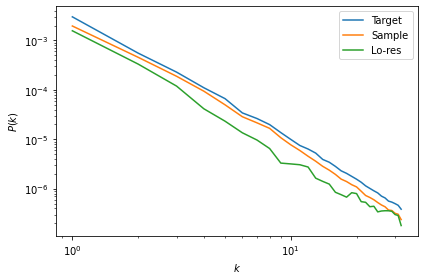

In [63]:
plt.loglog(kvals, np.mean(target_Abins, axis=0), label="Target")
plt.loglog(kvals, np.mean(sample_Abins, axis=0), label="Sample")
plt.loglog(kvals, np.mean(lo_res_Abins, axis=0), label="Lo-res")
plt.legend()
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.tight_layout()

plt.show()

In [8]:
s1 = np.s_[-int(npix / 2) : int(npix / 2)]
s2 = np.s_[-int(npix / 2) : int(npix / 2)]
yc, xc = np.ogrid[s1, s2]

r_grid = np.sqrt(xc * xc + yc * yc).round()

r_range = np.arange(0, int(npix / 2))

In [78]:
psd = np.fft.fftshift(np.fft.fftn(ds.sel(source="CPM")["target_pr"].values, axes=(1,2)), axes=(1,2))
psd = np.abs(psd) ** 2 #/ npix**2

In [80]:
result = []
for r in r_range:
    mask = r_grid == r
    psd_vals = psd[:, mask]
    result.append(np.mean(psd_vals))

result = np.array(result)

In [81]:
freq = np.fft.fftfreq(npix)
freq = freq[r_range]
freq*64

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31.])

In [82]:
kfreq

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31., -32.,
       -31., -30., -29., -28., -27., -26., -25., -24., -23., -22., -21.,
       -20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,
        -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.])

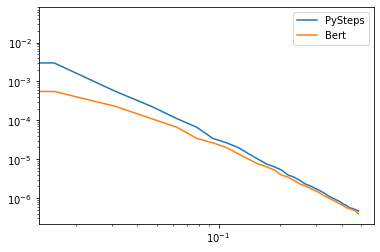

In [84]:
plt.loglog(freq, result, label="PySteps")
plt.loglog(freq, np.mean(target_Abins, axis=0), label="Bert")
plt.legend()

In [61]:
target_Abins.shape

(100, 32)

In [62]:
r_grid

array([[45., 45., 44., ..., 43., 44., 45.],
       [45., 44., 43., ..., 42., 43., 44.],
       [44., 43., 42., ..., 42., 42., 43.],
       ...,
       [43., 42., 42., ..., 41., 42., 42.],
       [44., 43., 42., ..., 42., 42., 43.],
       [45., 44., 43., ..., 42., 43., 44.]])

In [77]:
knrm

array([[0.        , 1.        , 2.        , ..., 3.        , 2.        ,
        1.        ],
       [1.        , 1.41421356, 2.23606798, ..., 3.16227766, 2.23606798,
        1.41421356],
       [2.        , 2.23606798, 2.82842712, ..., 3.60555128, 2.82842712,
        2.23606798],
       ...,
       [3.        , 3.16227766, 3.60555128, ..., 4.24264069, 3.60555128,
        3.16227766],
       [2.        , 2.23606798, 2.82842712, ..., 3.60555128, 2.82842712,
        2.23606798],
       [1.        , 1.41421356, 2.23606798, ..., 3.16227766, 2.23606798,
        1.41421356]])

In [71]:
kvals

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32.])

In [72]:
kfreq

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31., -32.,
       -31., -30., -29., -28., -27., -26., -25., -24., -23., -22., -21.,
       -20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,
        -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.])